In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install polars
#!pip install skorch
#!pip install pytorch_lightning
#!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 46.5 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

In [ ]:
import os

import copy
import numpy as np
import pandas as pd
#import polars as pl
import matplotlib
import matplotlib.pyplot as plt
import random
from itertools import cycle
from typing import Union, List, Optional
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.formula.api as smf
#import optuna
from torch import nn
from scipy.stats import norm
from scipy import stats

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import torch
from torch import nn
import torch.nn.functional as F
#import pytorch_lightning as pl
#from pytorch_lightning.loggers import WandbLogger

#from skorch import NeuralNetRegressor

In [ ]:
import os
os.chdir("/content/drive/MyDrive/practicum_data")
from share_funcs import *

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/practicum_data-American_Option/eurocall_fourier2.csv", index_col=0)
#data['euro_ame_diff'] = data.g_amercall_fde - data.g_eurocall
data.head()

,m,T,r,q,v0,theta,kappa,sigma,rho,eurocall_fourier
0,4.258717,1.680247,0.016304,0.041019,0.323511,1.807475,1.571375,0.067568,-0.773899,0.191405
1,2.274916,1.804915,0.058924,0.027882,0.496085,1.162404,0.670037,0.097001,-0.533752,0.226636
2,4.534160,0.670730,0.020643,0.030725,0.091455,1.815181,0.991059,0.493723,-0.425484,0.001174
3,4.753463,0.846062,0.026829,0.042381,0.145451,1.897037,0.809850,0.138594,-0.069301,0.007853
4,0.673201,0.114297,0.023764,0.021375,0.271200,0.301441,1.161399,0.331472,-0.601016,0.327119


In [ ]:
#data = pd.read_csv("/content/drive/MyDrive/practicum_data-American_Option/generated_data_50k.csv", index_col=0)
#data['g_eurocall'] = data['g_eurocall'].apply(lambda x: 0 if x < 1e-5 else x)
#data['euro_ame_diff'] = data.g_amercall_fde - data.g_eurocall
#(data.euro_ame_diff > 0).value_counts()

xgb_data = copy.deepcopy(data)

X_xgb = xgb_data.drop(columns=['eurocall_fourier'], axis=1)
#X_xgb = X_xgb.drop(columns=['g_eurocall'], axis=1)
y_xgb = xgb_data['eurocall_fourier']

#X_xgb['T_sigma'] = X_xgb.g_T * X_xgb.g_sigma
#X_xgb['T_q'] = X_xgb.g_T * X_xgb.g_q
#X_xgb['T_r'] = X_xgb.g_T * X_xgb.g_r

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=10)
train_size = int(0.8 * len(X_train_xgb))
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_xgb, y_train_xgb, test_size=0.3, random_state=10)

In [ ]:
X_test_xgb.head()

,m,T,r,q,v0,theta,kappa,sigma,rho
27632,1.577089,1.510236,0.052815,0.010955,0.234157,1.110906,1.107445,0.681154,-0.214079
36119,1.607342,1.520096,0.061065,0.021706,0.118032,1.037533,1.989870,0.226360,-0.712703
4796,4.753064,1.576210,0.073410,0.041019,0.313377,0.842204,0.311313,0.961561,0.279108
3648,2.219167,1.591208,0.061564,0.006440,0.073744,1.265429,1.141951,0.096655,-0.339541
24501,2.342002,1.616950,0.006100,0.013712,0.191482,0.171685,0.556774,0.127366,-0.249947


In [ ]:
data.shape

(200000, 6)

In [ ]:
class PricingDataset(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y:Union[pd.DataFrame, pd.Series]):
    """Initializes instance of class StudentsPerformanceDataset.
    Args:
        csv_file (str): Path to the csv file with the students data.
    """

    # Save target and predictors
    self.X = X.values.astype(np.float32)
    self.y = y.values.reshape(-1,1).astype(np.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
      # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
    #if isinstance(idx, torch.Tensor):
      #idx = idx.tolist()

    return self.X[idx], self.y[idx]


In [ ]:
class PricingNetwork(pl.LightningModule):
  def __init__(self, model, mean=X_train_xgb.mean(axis=0).values.astype(np.float32), std=X_train_xgb.std(axis=0).values.astype(np.float32), x_features=X_train_xgb.shape[1]):
    super().__init__()
    self.model = model
    self.mean = mean
    self.std = std

  def forward(self, x):
    x = (x - self.mean) / self.std
    return self.model(x)

  def training_step(self, batch, batch_idx):
    # training_step defines the train loop.
    x, y = batch
    y_pred = self(x)
    loss = F.mse_loss(y_pred, y)
    self.log("train_loss", loss, on_epoch=True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  def test_step(self, batch, batch_idx):
    # this is the test loop
    x, y = batch
    y_pred = self(x)
    test_loss = F.mse_loss(y_pred, y)
    #self.log("test_loss_quantile", pd.)
    self.log("test_loss", test_loss, on_epoch=True)

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self(x)
    loss = F.mse_loss(y_pred, y)
    # Calling self.log will surface up scalars for you in TensorBoard
    self.log("val_loss", loss, prog_bar=True, on_epoch=True)

    return self(batch)

In [ ]:
train_dataset = torch.utils.data.DataLoader(PricingDataset(X_train_xgb, y_train_xgb), batch_size=512)
val_dataset = torch.utils.data.DataLoader(PricingDataset(X_val_xgb, y_val_xgb), batch_size=512)
test_dataset = torch.utils.data.DataLoader(PricingDataset(X_test_xgb, y_test_xgb), batch_size=512)

In [ ]:
print(pricing)

PricingNetwork(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
neurons = 64
x_features = X_train_xgb.shape[1]
seq = nn.Sequential(nn.Linear(x_features, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     #nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, 1))
pricing = PricingNetwork(seq)
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model=pricing, train_dataloaders=train_dataset, val_dataloaders = val_dataset)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 17.3 K
-------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

<class 'torch.Tensor'>
<class 'list'>


ValueError: ignored

In [ ]:
test_loop(test_dataset, pricing, F.mse_loss)

Avg loss: 0.677896 



In [ ]:
def skorch_train():
  net = NeuralNetRegressor(
    PricingNetwork,
    optimizer=torch.optim.Adam,
    max_epochs=30,
    batch_size=512,
    criterion=nn.MSELoss(),
    #lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
  )
  X_train_ann = X_train_xgb.values.astype(np.float32)
  y_train_ann = y_train_xgb.values.reshape(-1,1).astype(np.float32)
  net.fit(X_train_ann,y_train_ann)


In [ ]:
skorch_train()

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0032        0.0001  2.3570
      2        0.0001        0.0000  2.3111
      3        0.0001        0.0000  2.3092
      4        0.0001        0.0000  2.8775
      5        0.0000        0.0000  3.7994
      6        0.0001        0.0000  2.3302
      7        0.0000        0.0000  2.2888
      8        0.0000        0.0000  2.3368
      9        0.0000        0.0000  2.3038
     10        0.0001        0.0000  3.5412
     11        0.0000        0.0000  3.1187
     12        0.0000        0.0000  2.3303
     13        0.0001        0.0000  2.3498
     14        0.0000        0.0000  2.3437
     15        0.0000        0.0001  2.7512
     16        0.0001        0.0000  3.9133
     17        0.0000        0.0000  2.3941
     18        0.0000        0.0000  2.3531
     19        0.0000        0.0000  2.3629
     20        0.0001        0.0000  2.3588
     21        0.0000        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=PricingNetwork2(
    (bottleneck): ModuleList(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=64, bias=True)
      (9): ReLU()
    )
    (final_layer): Linear(in_features=64, out_features=1, bias=True)
  ),
)

In [ ]:
class PricingNetwork2(nn.Module):
  def __init__(self, mean=X_train_xgb.mean(axis=0).values.astype(np.float32), std=X_train_xgb.std(axis=0).values.astype(np.float32), neurons=64, x_features=X_train_xgb.shape[1]):
  #def __init__(self, neurons=64, x_features=5):
    super(PricingNetwork2,self).__init__()
    self.mean = mean
    self.std = std
    self.bottleneck = nn.Sequential(nn.Linear(x_features, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     #nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU())
    #self.bottleneck = nn.ModuleList([nn.Linear(x_features, neurons), nn.LeakyReLU()] + [nn.Linear(neurons, neurons), nn.LeakyReLU()] * 4)
    self.final_layer = nn.Linear(neurons, 1)

  def forward(self, X, **kwargs):
    #X = (X - np.array([2.59564865,1.00528802,0.03986204,0.02523768,1.06051767], dtype=np.float32)) / np.array([1.38237971, 0.57541136, 0.02325452, 0.01445998, 0.55268058],dtype=np.float32)
    #(X - X.mean(axis=0))/X.std(axis=0)
    X = (X - self.mean) / self.std
    X = self.bottleneck(X)
    X  = self.final_layer(X)
    return X

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
#    train_loss = 0.
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
#        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#    return train_loss/num_batches



def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss = test_loss/num_batches
    return test_loss


In [ ]:
model = PricingNetwork2(x_features=X_train_xgb.shape[1],mean=X_train_xgb.mean(axis=0).values.astype(np.float32), std=X_train_xgb.std(axis=0).values.astype(np.float32))
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
epochs = 80
#train_losses = np.empty(epochs)
test_losses = np.empty(epochs)
val_losses = np.empty(epochs)
train_dataset = torch.utils.data.DataLoader(PricingDataset(X_train_xgb, y_train_xgb), batch_size=128)
val_dataset = torch.utils.data.DataLoader(PricingDataset(X_val_xgb, y_val_xgb), batch_size=128)
test_dataset = torch.utils.data.DataLoader(PricingDataset(X_test_xgb, y_test_xgb), batch_size=512)
for t in range(epochs):
    train_loop(train_dataset, model, loss_fn, optimizer)
    #train_losses[t] = train_loop(train_dataset, model, loss_fn, optimizer)
    val_loss = test_loop(val_dataset, model, loss_fn)
    test_loss = test_loop(test_dataset, model, loss_fn)
    val_losses[t] = val_loss
    test_losses[t] = test_loss
    #scheduler.step()
    scheduler.step(val_loss)

    if t > 25:
      print(f"Epoch {t+1}\n-------------------------------")
      print(f"Avg loss: {val_loss:>8f} \n")
print("Done!")

Epoch 27
-------------------------------
Avg loss: 0.003412 

Epoch 28
-------------------------------
Avg loss: 0.004373 

Epoch 29
-------------------------------
Avg loss: 0.003434 

Epoch 30
-------------------------------
Avg loss: 0.003815 

Epoch 31
-------------------------------
Avg loss: 0.003761 

Epoch 32
-------------------------------
Avg loss: 0.003228 

Epoch 33
-------------------------------
Avg loss: 0.003268 

Epoch 34
-------------------------------
Avg loss: 0.006025 

Epoch 35
-------------------------------
Avg loss: 0.003340 

Epoch 36
-------------------------------
Avg loss: 0.004839 

Epoch 37
-------------------------------
Avg loss: 0.004241 

Epoch 38
-------------------------------
Avg loss: 0.003175 

Epoch 39
-------------------------------
Avg loss: 0.003495 

Epoch 40
-------------------------------
Avg loss: 0.003243 

Epoch 41
-------------------------------
Avg loss: 0.004564 

Epoch 42
-------------------------------
Avg loss: 0.003480 

Epoch 43

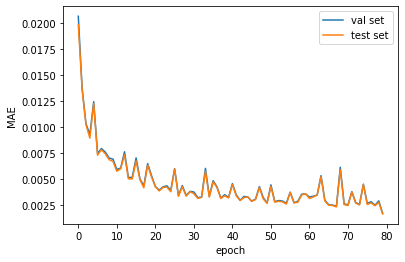

In [ ]:
plt.plot(val_losses, label="val set")
plt.plot(test_losses, label='test set');
plt.title("")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.legend()

In [ ]:
print('ANN Absolute Error (quantile): ')
val_dataset = torch.utils.data.DataLoader(PricingDataset(X_val_xgb, y_val_xgb), batch_size=128)
with torch.no_grad():
   print((y_val_xgb - pd.Series(model(torch.tensor(X_val_xgb.values.astype(np.float32))).flatten(), index=X_val_xgb.index)).abs().quantile([0,0.25,0.5,0.75,0.85,0.9,0.95, 0.99,1]).round(3))

ANN Absolute Error (quantile): 
0.00    0.000
0.25    0.000
0.50    0.001
0.75    0.002
0.85    0.003
0.90    0.004
0.95    0.005
0.99    0.009
1.00    0.650
dtype: float64


In [ ]:
with torch.no_grad():
  predict_ = pd.Series(model(torch.tensor(X_test_xgb.values.astype(np.float32))).flatten(), index=X_test_xgb.index)
predict_[predict_ < 0] = 0.

In [ ]:
ind_itm = X_test_xgb.m < 1
print((y_test_xgb[ind_itm] - predict_[ind_itm]).abs().quantile([0,0.25,0.5,0.75,0.85,0.9,0.95, 0.99,1]).round(3))

0.00    0.000
0.25    0.001
0.50    0.002
0.75    0.004
0.85    0.006
0.90    0.006
0.95    0.008
0.99    0.013
1.00    0.701
dtype: float64


In [ ]:
(y_test_xgb[ind_itm] - predict_[ind_itm]).abs().sort_values(ascending=False).head(50).index

Int64Index([14677,  9870, 45809,  2333, 39685, 22626, 10746, 39375, 32209,
            16589, 43384, 38188, 20297,  2353, 41986, 43911,  4421,  6864,
            31306,  6692, 20391,  5792, 37624, 40219, 32313, 39841, 17795,
            22245, 28648, 28416, 49556,  2637, 36916, 10448, 46717,  3756,
            22927, 32263, 13739,  8470, 18265, 44073, 19267, 28797, 14561,
            42161, 38359, 29663, 10023, 39949],
           dtype='int64')

In [ ]:
X_test_xgb.loc[[9870]]

,m,T,r,q,v0,theta,kappa,sigma,rho
9870,0.842425,0.001916,0.045908,0.044421,0.234685,1.334382,0.477893,0.432607,0.453099


In [ ]:
X_test_xgb.loc[[14677,  9870, 45809,  2333, 39685, 22626, 10746, 39375, 32209,
            16589, 43384, 38188, 20297,  2353, 41986, 43911,  4421,  6864,
            31306,  6692, 20391,  5792, 37624, 40219, 32313, 39841, 17795,
            22245, 28648, 28416, 49556,  2637, 36916, 10448, 46717,  3756,
            22927, 32263, 13739,  8470, 18265, 44073, 19267, 28797, 14561,
            42161, 38359, 29663, 10023, 39949],:]

,m,T,r,q,v0,theta,kappa,sigma,rho
14677,0.306817,0.001916,0.058351,0.024609,0.145724,1.873265,1.834680,0.821470,0.122932
9870,0.842425,0.001916,0.045908,0.044421,0.234685,1.334382,0.477893,0.432607,0.453099
45809,0.590916,1.842050,0.073313,0.022273,0.098367,1.399618,0.068381,0.949760,0.474702
2333,0.869552,0.051926,0.079534,0.040447,0.024720,0.132549,0.499828,0.980860,-0.879862
39685,0.580876,1.891920,0.038813,0.018660,0.364499,0.421284,0.192542,0.782965,0.890827
22626,0.229517,1.964997,0.057233,0.002600,0.402269,0.899304,0.122432,0.997124,0.363496
10746,0.986658,1.420549,0.037066,0.023402,0.103711,0.042812,0.025919,0.243253,-0.434397
39375,0.767655,1.977395,0.003649,0.033063,0.218058,0.476168,0.112508,0.250753,0.595622
32209,0.895364,0.883997,0.020326,0.014143,0.042890,0.019095,1.396961,0.759487,0.678637
16589,0.219077,1.389378,0.019148,0.029049,0.377340,0.068075,0.477467,0.252281,0.086789


In [ ]:
pd.concat([y_test_xgb[ind_itm],predict_[ind_itm]], axis=1).loc[(y_test_xgb[ind_itm] - predict_[ind_itm]).abs().sort_values(ascending=False).head(50).index]

,eurocall_fourier,0
14677,0.000000,0.701283
9870,0.000000,0.149616
45809,0.462180,0.435609
2333,0.132113,0.151808
39685,0.469654,0.487611
22626,0.798086,0.815389
10746,0.154220,0.136956
39375,0.325183,0.308076
32209,0.116622,0.133631
16589,0.748105,0.731518


In [ ]:
(y_test_xgb - predict_).abs().sort_values(ascending=False).head(50)

14677    0.701283
9870     0.149616
46558    0.037334
42867    0.030292
47247    0.029382
35373    0.027949
45809    0.026571
43269    0.024211
31932    0.023699
19130    0.020664
29442    0.020481
2333     0.019696
39685    0.017957
22626    0.017303
10746    0.017264
39375    0.017106
32209    0.017009
16589    0.016588
43384    0.016490
20470    0.016278
38188    0.016153
20297    0.015750
2353     0.015452
17337    0.015322
13956    0.015248
10232    0.015211
41986    0.014783
9907     0.014713
38905    0.014547
43911    0.014337
4421     0.014321
38037    0.014300
6864     0.014125
31306    0.013966
6692     0.013931
29091    0.013844
13854    0.013842
48153    0.013723
38623    0.013618
20391    0.013501
5792     0.013476
37624    0.013472
40219    0.013372
43249    0.013347
32313    0.013346
10415    0.013336
39841    0.013254
26917    0.013141
17795    0.013043
38215    0.013025
dtype: float64

In [ ]:
(y_test_xgb[ind_tm]).shape

(2724,)

In [ ]:
ind_otm = X_test_xgb.m > 1
print((y_test_xgb[ind_otm] - predict_[ind_otm]).abs().quantile([0,0.25,0.5,0.75,0.85,0.9,0.95, 0.99,1]).round(3))

0.00    0.000
0.25    0.000
0.50    0.001
0.75    0.002
0.85    0.003
0.90    0.003
0.95    0.004
0.99    0.007
1.00    0.037
dtype: float64


In [ ]:
print('ANN Absolute Error (quantile): ')
test_dataset = torch.utils.data.DataLoader(PricingDataset(X_test_xgb, y_test_xgb), batch_size=512)
with torch.no_grad():
   print((y_test_xgb - pd.Series(model(torch.tensor(X_test_xgb.values.astype(np.float32))).flatten(), index=X_test_xgb.index)).abs().quantile([0,0.25,0.5,0.75,0.85,0.9,0.95, 0.99,1]).round(3))

ANN Absolute Error (quantile): 
0.00    0.000
0.25    0.000
0.50    0.001
0.75    0.002
0.85    0.003
0.90    0.004
0.95    0.006
0.99    0.009
1.00    0.701
dtype: float64


In [ ]:
def train_epoch(epoch):
  train_dataset = torch.utils.data.DataLoader(PricingDataset(X_train_xgb, y_train_xgb), batch_size=128)
  val_dataset = torch.utils.data.DataLoader(PricingDataset(X_val_xgb, y_val_xgb), batch_size=128)
  for t in range(epochs):
      train_loop(train_dataset, model, loss_fn, optimizer)
      val_loss = test_loop(val_dataset, model, loss_fn)
      scheduler.step(val_loss)
      if t > 25:
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Avg loss: {val_loss:>8f} \n")
  print("Done!")

In [ ]:
torch.save(model, '/content/drive/MyDrive/practicum_data-American_Option/euro_transform.pt')

In [ ]:
mm = torch.load('/content/drive/MyDrive/practicum_data-American_Option/without_eurocall.pt')
print('ANN Absolute Error (quantile): ')
with torch.no_grad():
   print((y_test_xgb - pd.Series(mm(torch.tensor(X_test_xgb.values.astype(np.float32))).flatten(), index=X_test_xgb.index)).abs().quantile([0,0.25,0.5,0.75,0.85,0.9,0.95, 0.99,1]).round(3))

ANN Absolute Error (quantile): 
0.00    0.000
0.25    0.000
0.50    0.001
0.75    0.003
0.85    0.004
0.90    0.005
0.95    0.007
0.99    0.012
1.00    0.048
dtype: float64


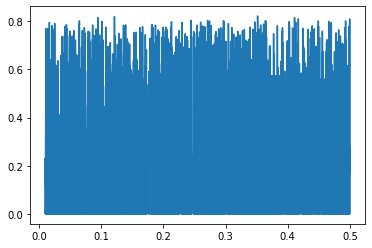

In [ ]:
x_ = X_test_xgb.sort_values(by="v0")
y_ = y_test_xgb[x_.index]
plt.plot(x_.v0, y_)

In [ ]:
train_epoch(35)

Epoch 27
-------------------------------
Avg loss: 0.000004 

Epoch 28
-------------------------------
Avg loss: 0.000004 

Epoch 29
-------------------------------
Avg loss: 0.000003 

Epoch 30
-------------------------------
Avg loss: 0.000006 

Epoch 31
-------------------------------
Avg loss: 0.000004 

Epoch 32
-------------------------------
Avg loss: 0.000003 

Epoch 33
-------------------------------
Avg loss: 0.000003 

Epoch 34
-------------------------------
Avg loss: 0.000003 

Epoch 35
-------------------------------
Avg loss: 0.000003 

Epoch 36
-------------------------------
Avg loss: 0.000003 

Epoch 37
-------------------------------
Avg loss: 0.000003 

Epoch 38
-------------------------------
Avg loss: 0.000002 

Epoch 39
-------------------------------
Avg loss: 0.000003 

Epoch 40
-------------------------------
Avg loss: 0.000005 

Epoch 41
-------------------------------
Avg loss: 0.000003 

Epoch 42
-------------------------------
Avg loss: 0.000007 

Epoch 43

In [ ]:
X_test_xgb.shape

(15000, 9)